In [1]:
import os
import cv2
import time
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from functools import partial
from google.colab import drive
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn import preprocessing
from  matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
%matplotlib inline
from keras.applications import VGG16
from keras.layers import Flatten, Dense, BatchNormalization, Input, Concatenate, RepeatVector, Reshape, Lambda, concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import backend as K

import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')
dir_path = 'drive/My Drive/DSCI552/Project/'
# dir_path = 'drive/My Drive/USC Courses/DSCI552 - Machine Learning for Data Science/'

if not os.path.exists(dir_path):
    try:
        os.mkdir(dir_path)
        print(f'Created directory: {dir_path}')
    except OSError:
        print(f'Error creating directory: {dir_path}')
else:
    print(f'Changed to directory: {dir_path}')
    os.chdir(dir_path)

Mounted at /content/drive
Changed to directory: drive/My Drive/DSCI552/Project/


# Data Collection

In [3]:
# Define function to read data from training set on disk/drive
def create_dataset(img_folder, img_width, img_height):
    img_data_array, category_class, landmark_class = [], [], []
    valid_extensions = (".jpeg", ".jpg", ".JPG", ".webp", ".png")

    for category in os.listdir(img_folder):
        category_dir = os.path.join(img_folder, category)
        if not os.path.isdir(category_dir):
            continue

        for landmark in os.listdir(category_dir):
            landmark_dir = os.path.join(category_dir, landmark)
            if not os.path.isdir(landmark_dir):
                continue

            for file in os.listdir(landmark_dir):
                _, ext = os.path.splitext(file)
                if ext.lower() not in valid_extensions:
                    print(f"bad file type: {file}")
                    continue

                image_path = os.path.join(landmark_dir, file)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"failed to load image: {image_path}")
                    continue

                image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_AREA)
                image = np.array(image, dtype='float32') / 255
                img_data_array.append(image)
                category_class.append(category)
                landmark_class.append(landmark)

    return img_data_array, category_class, landmark_class

In [4]:
img_width = 224
img_height = 224
batch_size = 32
img_size = (224, 224, 3)

img_folder = 'Landmarks-v1_1/'

In [5]:
if os.path.exists(img_folder):
    print("File exists!")
else:
    print("File does not exist.")

File exists!


In [6]:
# Extract image array and class names
data_array, category_class, landmark_class = create_dataset(img_folder,img_width,img_height)
print(f"Len: {len(data_array)}, Type: {type(data_array)}, Type of 1st elem: {type(data_array[0])}")

failed to load image: Landmarks-v1_1/Neoclassical/Buckingham Palace/Buckingham Palace_19.jpg
failed to load image: Landmarks-v1_1/Neoclassical/Academy of Athens/Academy of Athens - 20.jpg
failed to load image: Landmarks-v1_1/Mughal/Bibi Ka Maqbara/Bibi Ka Maqbara - 14.jpg
Len: 417, Type: <class 'list'>, Type of 1st elem: <class 'numpy.ndarray'>


# Data Prep

In [7]:
# Split the category data into training and test sets
X_train_valid, X_test, y_train_valid, y_test = train_test_split(data_array, category_class, test_size=0.2, random_state=1)

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=1)

# Convert the lists to NumPy arrays
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

# Split the landmark data into training and test sets
X_train_valid_L, X_test_L, y_train_valid_L, y_test_L = train_test_split(data_array, landmark_class, test_size=0.2, random_state=1)

# Split the training data into training and validation sets
X_train_L, X_valid_L, y_train_L, y_valid_L = train_test_split(X_train_valid, y_train_valid_L, test_size=0.25, random_state=1)

# Convert the lists to NumPy arrays
X_train_L = np.array(X_train_L)
X_valid_L = np.array(X_valid_L)
X_test_L = np.array(X_test_L)

# Print the shape of the resulting datasets
print("Category Training set shape:", X_train.shape)
print("Category Validation set shape:", X_valid.shape)
print("Category Test set shape:", X_test.shape)
print("\n")
print("Landmark Training set shape:", X_train_L.shape)
print("Landmark Validation set shape:", X_valid_L.shape)
print("Landmark Test set shape:", X_test_L.shape)



Category Training set shape: (249, 224, 224, 3)
Category Validation set shape: (84, 224, 224, 3)
Category Test set shape: (84, 224, 224, 3)


Landmark Training set shape: (249, 224, 224, 3)
Landmark Validation set shape: (84, 224, 224, 3)
Landmark Test set shape: (84, 224, 224, 3)


In [8]:
# Transforms categorical labels into numerical labels
le = preprocessing.LabelEncoder()
le.fit(['Pagodas','Pyramids','Modern','Gothic','Mughal','Neoclassical'])
y_train_encoded = le.transform(y_train)
y_valid_encoded = le.transform(y_valid)
y_test_encoded = le.transform(y_test)
# print(y_train_encoded)

# Reverse the encoding to match the order of the classes list in the graders notebook
class_order = ['Pagodas','Pyramids','Modern','Gothic','Mughal','Neoclassical']
y_train_encoded_new = [class_order.index(c) for c in y_train]
y_valid_encoded_new = [class_order.index(c) for c in y_valid]
y_test_encoded_new = [class_order.index(c) for c in y_test]
# print(y_train_encoded_new)

# Convert true labels to one-hot encoding for both training and validation sets
y_train_encoded_onehot = to_categorical(y_train_encoded_new)
y_valid_encoded_onehot = to_categorical(y_valid_encoded_new)
y_test_encoded_onehot = to_categorical(y_test_encoded_new)
# print(y_train_encoded_onehot)

# Reverse the encoding to match the order of the classes list
class_order = [
        'TianningTemplePagoda','ThienMuPagoda','GiantWildGoosePagoda','ShwedagonPagoda',
        'FogongTemplePagoda','Pyramid of Giza','Pyramid of Djoser','Santa Cecilia Acatitlan Pyramid',
        'El Castillo, Chichen Itza','Louvre Pyramid','Chrysler Building','Cathedral of Brasília',
        'CCTV Headquarters','Hallgrímskirkja','eiffel','St.VitusCathedral',
        'MilanCathedral','ChartresCathedral','CologneCathedral','Notre-DameCathedral',
        'Taj Mahal','Tomb of Akbar','Jama Masjid','Tomb of I_timad-ud-Daulah',
        'Bibi Ka Maqbara','Buckingham Palace','Concertgebouw',
        'Academy of Athens','Panthéon','Ripon Building','other']
y_train_encoded_new_L = [class_order.index(c) for c in y_train_L]
y_valid_encoded_new_L = [class_order.index(c) for c in y_valid_L]
y_test_encoded_new_L = [class_order.index(c) for c in y_test_L]
# print(y_train_encoded_new_L)

# Convert true labels to one-hot encoding for both training and validation sets
y_train_encoded_onehot_L = to_categorical(y_train_encoded_new_L)
y_valid_encoded_onehot_L = to_categorical(y_valid_encoded_new_L)
y_test_encoded_onehot_L = to_categorical(y_test_encoded_new_L)
# print(y_train_encoded_onehot_L)

['Gothic', 'Pagodas', 'Pagodas', 'Mughal', 'Pagodas', 'Mughal', 'Neoclassical', 'Mughal', 'Gothic', 'Mughal', 'Pyramids', 'Neoclassical', 'Neoclassical', 'Mughal', 'Pyramids', 'Neoclassical', 'Modern', 'Gothic', 'Neoclassical', 'Mughal', 'Gothic', 'Modern', 'Pagodas', 'Gothic', 'Mughal', 'Mughal', 'Gothic', 'Pyramids', 'Gothic', 'Mughal', 'Pagodas', 'Mughal', 'Pagodas', 'Neoclassical', 'Gothic', 'Gothic', 'Neoclassical', 'Mughal', 'Modern', 'Mughal', 'Pyramids', 'Pagodas', 'Neoclassical', 'Gothic', 'Pagodas', 'Neoclassical', 'Modern', 'Gothic', 'Pagodas', 'Pagodas', 'Mughal', 'Gothic', 'Neoclassical', 'Modern', 'Neoclassical', 'Gothic', 'Pagodas', 'Mughal', 'Pagodas', 'Mughal', 'Mughal', 'Pyramids', 'Modern', 'Neoclassical', 'Pyramids', 'Pyramids', 'Gothic', 'Pyramids', 'Modern', 'Neoclassical', 'Pagodas', 'Gothic', 'Pagodas', 'Modern', 'Neoclassical', 'Pyramids', 'Gothic', 'Modern', 'Gothic', 'Neoclassical', 'Modern', 'Pyramids', 'Mughal', 'Mughal', 'Pagodas', 'Mughal', 'Modern', 'Pyr

In [10]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the augmentation on the training data
train_datagen.fit(X_train)
train_datagen.fit(X_train_L)

# Category Model 

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
8/8 [==============================] - 24s 1s/step - loss: 2.2977 - accuracy: 0.2410 - val_loss: 0.9171 - val_accuracy: 0.6429
Epoch 2/30
8/8 [==============================] - 3s 381ms/step - loss: 0.9734 - accuracy: 0.6586 - val_loss: 0.7009 - val_accuracy: 0.7738
Epoch 3/30
8/8 [==============================] - 4s 507ms/step - loss: 0.7488 - accuracy: 0.7470 - val_loss: 0.5856 - val_accuracy: 0.7500
Epoch 4/30
8/8 [==============================] - 3s 432ms/step - loss: 0.4811 - accuracy: 0.8594 - val_loss: 0.3656 - val_accuracy: 0.8929
Epoch 5/30
8/8 [==============================] - 3s 378ms/step - loss: 0.3938 - accuracy: 0.8876 - val_loss: 0.3312 - val_accuracy: 0.8810
Epoch 6/30
8/8 [==============================] - 4s 475ms/step - loss: 0.3030 - accuracy: 0.9116 - val_loss: 0.3281 - val_accuracy: 0.9048
Epoch 7/30
8/8 [==============================] - 3s 421ms/step - loss: 0.2548 - accuracy: 0.9277

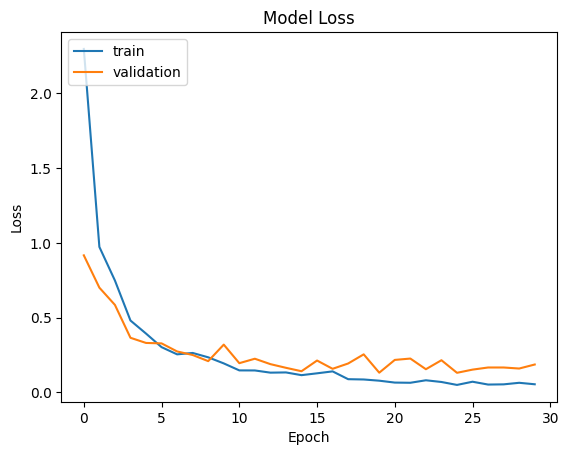

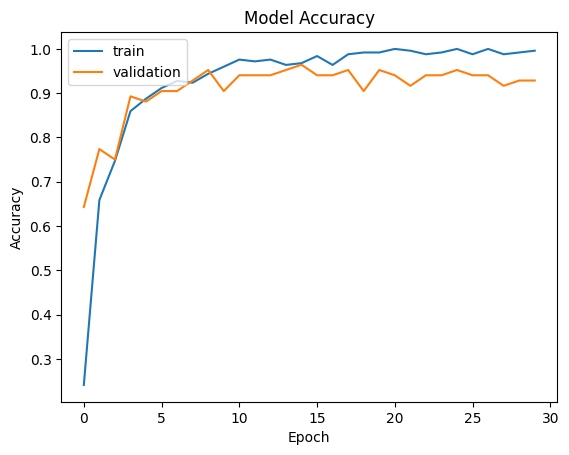

In [11]:
# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add classification layers
x = Flatten()(base_model.output)
num_category_classes = 6
predictions = Dense(num_category_classes, activation='softmax')(x)

# Create the model
category_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
category_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import EarlyStopping

# Set early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = category_model.fit(train_datagen.flow(X_train, y_train_encoded_onehot, batch_size=32),
                    epochs=30,
                    validation_data=(X_valid, y_valid_encoded_onehot),
                    callbacks=[early_stopping])

# Evaluate the model on the validation set
loss, accuracy_score = category_model.evaluate(X_valid, y_valid_encoded_onehot)
print('Validation accuracy:', accuracy_score)

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [12]:
# Calculate the f1_score using sklearn
y_pred = category_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
f1score = f1_score(y_test_encoded_new, y_pred_classes, average='macro')
print('Test f1_score:', f1score)

3/3 [==============================] - 0s 118ms/step
Test f1_score: 0.8849355934442422


In [13]:
# category_model.save('category_model.h5')

# Landmark Classifier 

553467096/553467096 [==============================] - 2s 0us/step
Epoch 1/30
8/8 [==============================] - 5s 502ms/step - loss: 4.2102 - accuracy: 0.0924 - val_loss: 3.1175 - val_accuracy: 0.2619
Epoch 2/30
8/8 [==============================] - 5s 572ms/step - loss: 2.5408 - accuracy: 0.3373 - val_loss: 1.9055 - val_accuracy: 0.4405
Epoch 3/30
8/8 [==============================] - 3s 380ms/step - loss: 1.4518 - accuracy: 0.5944 - val_loss: 1.6800 - val_accuracy: 0.5952
Epoch 4/30
8/8 [==============================] - 3s 395ms/step - loss: 1.0987 - accuracy: 0.7068 - val_loss: 1.6328 - val_accuracy: 0.6429
Epoch 5/30
8/8 [==============================] - 4s 521ms/step - loss: 0.7685 - accuracy: 0.8032 - val_loss: 1.2346 - val_accuracy: 0.6310
Epoch 6/30
8/8 [==============================] - 3s 422ms/step - loss: 0.6349 - accuracy: 0.8313 - val_loss: 1.2490 - val_accuracy: 0.6905
Epoch 7/30
8/8 [==============================] - 3s 420ms/step - loss: 0.3969 - accuracy: 0.

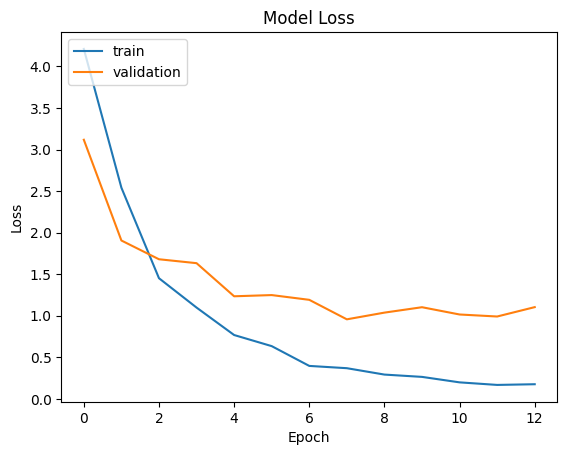

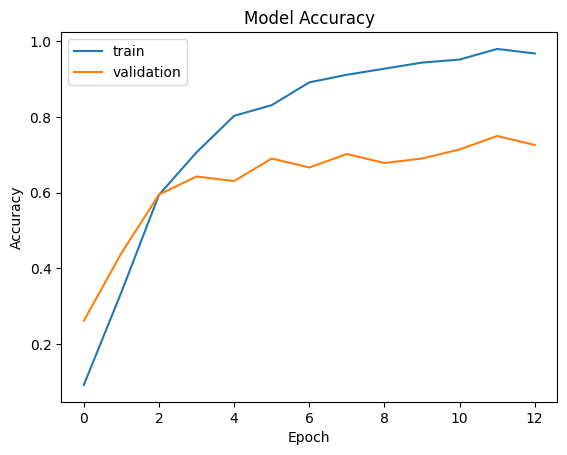

In [14]:
# Load the pre-trained model (transfer learning)
base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Extract the output tensor from the base model
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

# Add classification layers
num_category_classes = 30
x = Flatten()(last_output)
predictions = Dense(num_category_classes, activation='softmax')(x)

# Create the model
landmark_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.001)
landmark_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history2 = landmark_model.fit(train_datagen.flow(X_train_L, y_train_encoded_onehot_L, batch_size=32),
                    epochs=30,
                    validation_data=(X_valid_L, y_valid_encoded_onehot_L),
                    callbacks=[early_stopping])

# Evaluate the model on the validation set
loss, accuracy_score = landmark_model.evaluate(X_valid_L, y_valid_encoded_onehot_L)
print('Validation accuracy:', accuracy_score)

# Plot the training and validation loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the training and validation accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [15]:
# Calculate the f1_score using sklearn
y_pred_L = landmark_model.predict(X_test_L)
y_pred_classes_L = np.argmax(y_pred_L, axis=1)
f1score = f1_score(y_test_encoded_new_L, y_pred_classes_L, average='macro')
print('Test f1_score:', f1score)

3/3 [==============================] - 0s 115ms/step
Test f1_score: 0.7572077922077922


In [16]:
# landmark_model.save('landmark_model.h5')